# Lineare Regression mit mehreren Features ($d>1$)

In [1]:
import numpy as np
import pandas as pd
# plotting settings
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

Wir verwenden hier beispielhaft den Datensatz [Melbourne Housing Snapshot](https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot). Diesen finden Sie auch im Moodle unter `data/kaggle/melb_data.csv`.

In [2]:
melbourne_file_path = 'data/melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path)
melbourne_data = melbourne_data.dropna(axis=0)  # entfernen von Daten mit fehlenden Werten
melbourne_data.columns  # Spaltennamen der Tabelle (potentielle Features)

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [3]:
melbourne_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0


In [4]:
#features = ['BuildingArea', Rooms', 'Bathroom', 'Landsize', 'Lattitude', 'Longtitude', 'YearBuilt', 'Distance']
features = ['Rooms', 'BuildingArea']
data = melbourne_data[features + ['Price']]

In [5]:
data.describe()

,Rooms,BuildingArea,Price
count,6196.000000,6196.000000,6.196000e+03
mean,2.931407,141.568645,1.068828e+06
std,0.971079,90.834824,6.751564e+05
min,1.000000,0.000000,1.310000e+05
25%,2.000000,91.000000,6.200000e+05
50%,3.000000,124.000000,8.800000e+05
75%,4.000000,170.000000,1.325000e+06
max,8.000000,3112.000000,9.000000e+06


In [6]:
data.head()

,Rooms,BuildingArea,Price
1,2,79.0,1035000.0
2,3,150.0,1465000.0
4,4,142.0,1600000.0
6,3,210.0,1876000.0
7,2,107.0,1636000.0


## Definition der Funktionen für die Lineare Regression

Aus der Vorlesung:

$$ h(x, w) = w^T x . $$

In der Vorlesung haben wir $\theta$ statt $w$ verwendet.

**Wichtig:** Diese Definition von $h$ nimmt an, dass die erste Komponente von $x$, also in Python code `x[0]`, immer 1 ist.

Wir können auch eine vektorisierte Form von $h(x, w)$ definieren, bei der der Input $X$ mehrere (oder alle) Trainingsbeispiele umfasst und der Output ein Vektor aus den zugehörigen Werten von h zu jedem der Trainingsbeispiele ist. In Matrixschreibweise:

$$ h(X, w) = X w , $$

wobei die Zeilen von $X$ aus je einem Trainingsbeispiel (inkl. der "1" in der ersten Komponente) bestehen.

Aufgrund der Art wie `numpy` den Spezialfall der Multiplikation zweier Vektoren handhabt können wir den Code für beide oben erwähnten Varianten von $h$ vereinheitlichen und eine Funktion $h(x, w)$ definieren, die sowohl mit einer Inputzeile als auch mit mehreren Inputzeilen umgehen kann.

Bei der Multiplikation zweier numpy arrays (also zweier Vektoren) mittels `@`-Operator bildet numpy stets das Skalarprodukt der Vektoren, ohne dass man einen der Vektoren transponieren müsste. D.h., wenn wir zwei Spaltenvektoren $w, x$ haben, lautet die korrekte Schreibweise eigentlich:
$$w^T x$$
numpy erlaubt es uns aber einfach `w @ x` oder auch `x @ w` zu schreiben anstelle (des ebenfalls möglichen) `w.T @ x`.

Dies ermöglicht es uns eine vektorisierte Form von $h(x, w)$ leicht aufzuschreiben, die sowohl mit einem Parameter `x` bestehend aus einer Zeile an Inputdaten (also z.B. einem einzelnen Trainingsbeispiel) funktioniert als auch mit der gesamten Feature-Matrix `X`, bestehend aus allen (oder mehreren) Trainingsdaten auf einmal.

In [7]:
def h(x, w):
    """x und w sind numpy arrays; x kann auch die komplette Feature-Matrix sein"""
    # Diese Form erlaubt es für x eine ganze (Feature-)Matrix zu übergeben. Die Matrix enthält
    # zeilenweise je einen Datenpunkt, für den h berechnet werden soll.
    # w @ x.T ist dann ein Vektor mit je einem Ergebnis in den Komponenten des Vektors pro Zeile
    # der übergebenen (Feature-)Matrix.
    return x @ w

In [8]:
# Definition der Kostenfunktion
def J(w, X, y):
    """
    w, X, y müssen numpy arrays sein
    X: Feature-Matrix aller Trainingsdaten inkl. Spalte mit 1; Dimension: n x (d+1)
    y: Vektor aller Targets zu X
    """
    errors = y - h(x=X, w=w)
    mse = 1.0/(2.0*len(y)) * ( errors @ errors )
    return mse

In [9]:
data.shape

(6196, 3)

In [10]:
np.ones((len(data),1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [11]:
def feature_matrix_from_data(data):
    # hier erzeugen wir die Matrix mit unseren Input-Daten (Features) inklusive der Spalte mit "1"
    return np.hstack((np.ones((len(data),1)), data.to_numpy(copy=True)))

In [12]:
# hier erzeugen wir die Matrix mit unseren Input-Daten (Features) inklusive der Spalte mit "1"
#X = np.hstack((np.ones((len(data),1)), data[features].to_numpy(copy=True)))
X = feature_matrix_from_data(data[features])
# und ausserdem den Vektor der Targets
y = data.Price.to_numpy(copy=True)

In [13]:
X.shape

(6196, 3)

In [14]:
X

array([[  1.  ,   2.  ,  79.  ],
       [  1.  ,   3.  , 150.  ],
       [  1.  ,   4.  , 142.  ],
       ...,
       [  1.  ,   1.  ,  35.64],
       [  1.  ,   2.  ,  61.6 ],
       [  1.  ,   6.  , 388.5 ]])

**Hinweis:** Die Matrix $X$ hat zwar die gleiche Dimension wie `data`, allerdings enthält data eine Spalte `Price`, die in $X$ nicht enthalten ist. Dafür hat $X$ als erste Spalte die "1er".

## Analytische Lösung der linearen Regression

Die analytische Lösung verläuft identisch zum Fall mit nur einem Feature.

`np.linalg.solve(A, b)` berechnet $w$ im linearen Gleichungssystem

$ A w = b $

$A$ - Matrix,
$w$ - Vektor (unsere unbekannten),
$b$ - Vektor.

Wir suchen die Lösung $w$ im folgenden Gleichungssystem:

$$ X^T X w = X^T Y $$

Mit $A = X^TX$ und $b = X^T Y$ berechnet `np.linalg.solve(A, b)` unsere gesuchten Paramter für die lineare Regression.

In [15]:
%%time
w_ana = np.linalg.solve(X.T @ X, X.T @ y)
print('Die {} Parameter der linearen Regression:\n{}'.format(len(w_ana), w_ana))
J_ana = J(w=w_ana, X=X, y=y)
print('Kostenfunktion J(w_ana): {}'.format(J_ana))

Die 3 Parameter der linearen Regression:
[ 42769.88494072 232612.86504788   2431.15453776]
Kostenfunktion J(w_ana): 147658829426.14856
CPU times: user 1.95 ms, sys: 183 µs, total: 2.13 ms
Wall time: 507 µs


## Numerische Lösung mit Gradient Descent

In [16]:
## Numerische Lösung mit Gradient Descent
def grad_desc_upd(w, alpha, x, y):
    """y, x sind Vektoren (numpy-arrays)"""
    errors = y - h(x=x, w=w)
    w = w + alpha / len(y) * (x.T @ errors)
    return w

In [17]:
def grad_desc(w, alpha, x, y, n_iterations):
    J_all = [[0], [J(w=w, X=x, y=y)]]
    for it in tqdm(range(n_iterations)):
        w = grad_desc_upd(w=w, alpha=alpha, x=x, y=y)
        if it % 100 == 0:
            J_all[1].append(J(w=w, X=x, y=y))
            J_all[0].append(it)
    return w, J_all

In [18]:
grad_desc_upd(w=np.ones(X.shape[1]), alpha=1e-6, x=X[:7], y=y[:7])

array([  2.43686014,   5.00088371, 206.19316114])

In [19]:
%%time
w_init = np.ones(X.shape[1])
alpha = 3.1e-10  # verschiedene alpha ausprobieren
n_iterations = 10000
_, J_tmp = grad_desc(w=w_init, alpha=alpha, x=X, y=y, n_iterations=n_iterations)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2.87 s, sys: 1.17 s, total: 4.04 s
Wall time: 455 ms


In [20]:
%%time
w_init = np.ones(X.shape[1])
alpha = 1e-10  # verschiedene alpha ausprobieren
n_iterations = 100000
w_gd, J_all = grad_desc(w=w_init, alpha=alpha, x=X, y=y, n_iterations=n_iterations)
print('Die {} Parameter der linearen Regression:\n{}'.format(len(w_gd), w_gd))
print('Kostenfunktion J: {}'.format(J_all[1][-1]))
print('J relativ zu Startkosten: {}'.format(J_all[1][-1]/J_all[1][0]))
print('Vergleich Kostenfunktion zu analytischer Lösung: {:.2f}*J_ana'.format(J_all[1][-1]/J_ana))
print('Relative Abweichung der Parameter zu analytischer Lösung: {}*w_ana'.format((w_gd)/w_ana))

  0%|          | 0/100000 [00:00<?, ?it/s]

Die 3 Parameter der linearen Regression:
[  10.49970832   31.89447067 1601.95876825]
Kostenfunktion J: 540959857400.77966
J relativ zu Startkosten: 0.6771395257663181
Vergleich Kostenfunktion zu analytischer Lösung: 3.66*J_ana
Relative Abweichung der Parameter zu analytischer Lösung: [2.45493022e-04 1.37113958e-04 6.58929222e-01]*w_ana
CPU times: user 26 s, sys: 6.48 s, total: 32.5 s
Wall time: 3.53 s


<Axes: >

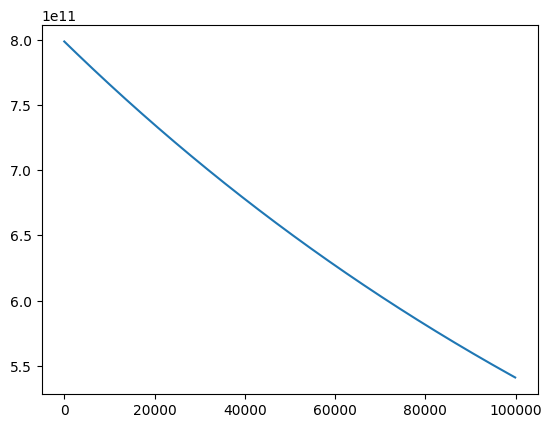

In [21]:
sns.lineplot(x=J_all[0], y=J_all[1])

In [22]:
%%time
alpha = 3.1e-10  # verschiedene alpha ausprobieren
n_iterations = 1000000
w_gd2, J_all2 = grad_desc(w=w_gd, alpha=alpha, x=X, y=y, n_iterations=n_iterations)
print('Die {} Parameter der linearen Regression:\n{}'.format(len(w_gd2), w_gd2))
print('Kostenfunktion J: {}'.format(J_all2[1][-1]))
print('J relativ zu Startkosten: {}'.format(J_all2[1][-1]/J_all2[1][0]))
print('Vergleich Kostenfunktion zu analytischer Lösung: {:.5f}*J_ana'.format(J_all2[1][-1]/J_ana))
print('Relative Abweichung der Parameter zu analytischer Lösung: {}*w_ana'.format((w_gd2)/w_ana))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Die 3 Parameter der linearen Regression:
[  81.08915614  248.45370379 6493.32860783]
Kostenfunktion J: 201611248738.63248
J relativ zu Startkosten: 0.37282268754553793
Vergleich Kostenfunktion zu analytischer Lösung: 1.36539*J_ana
Relative Abweichung der Parameter zu analytischer Lösung: [1.89594048e-03 1.06809958e-03 2.67088270e+00]*w_ana
CPU times: user 4min 11s, sys: 1min 8s, total: 5min 19s
Wall time: 34.4 s


<Axes: >

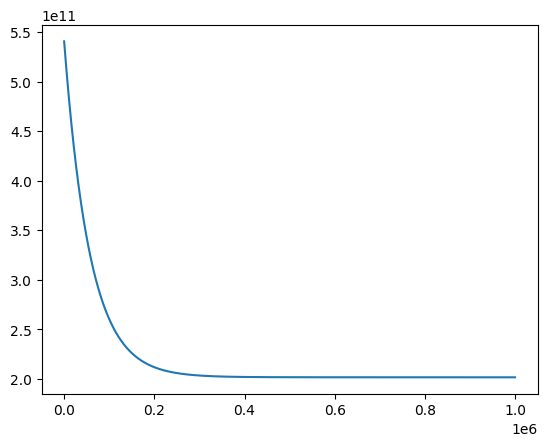

In [23]:
sns.lineplot(x=J_all2[0], y=J_all2[1])

In [24]:
%%time
alpha = 3.1e-10  # verschiedene alpha ausprobieren
n_iterations = 10000000
w_gd3, J_all3 = grad_desc(w=w_gd2, alpha=alpha, x=X, y=y, n_iterations=n_iterations)

print('Die {} Parameter der linearen Regression:\n{}'.format(len(w_gd3), w_gd3))
print('Kostenfunktion J: {}'.format(J_all3[1][-1]))
print('J relativ zu Startkosten: {}'.format(J_all3[1][-1]/J_all3[1][0]))
print('Vergleich Kostenfunktion zu analytischer Lösung: {:.2f}*J_ana'.format(J_all3[1][-1]/J_ana))
print('Relative Abweichung der Parameter zu analytischer Lösung: {}*w_ana'.format((w_gd3)/w_ana))

  0%|          | 0/10000000 [00:00<?, ?it/s]

Die 3 Parameter der linearen Regression:
[ 540.5020477  1598.80804052 6469.41806027]
Kostenfunktion J: 200954758401.09796
J relativ zu Startkosten: 0.9967438136028319
Vergleich Kostenfunktion zu analytischer Lösung: 1.36*J_ana
Relative Abweichung der Parameter zu analytischer Lösung: [0.01263744 0.00687326 2.66104765]*w_ana
CPU times: user 37min 33s, sys: 9min 27s, total: 47min 1s
Wall time: 5min 1s


<Axes: >

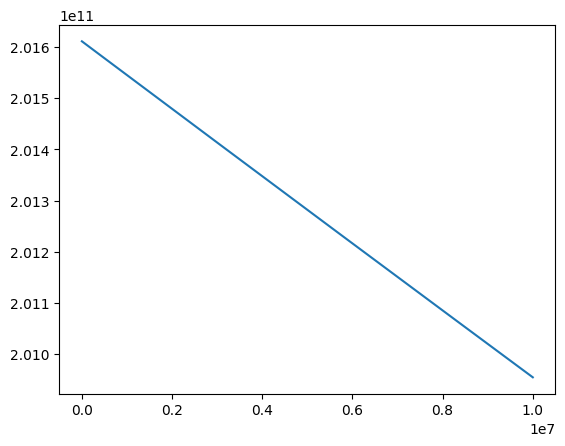

In [27]:
sns.lineplot(x=J_all3[0], y=J_all3[1])

## $R^2$

In [28]:
X = feature_matrix_from_data(data[features])
y = data.Price.to_numpy(copy=True)
J_ana = J(w=w_ana, X=X, y=y)
MSE = 2*J_ana
mu_y = sum(y)/len(y)
sigma_y_quadrat = ( (y - mu_y) @ (y - mu_y) ) / len(y)
R2 = 1 - MSE/sigma_y_quadrat
print('erklärte Varianz (R^2): {}'.format(R2))

erklärte Varianz (R^2): 0.3520362618371272


$R^2$ ist größer als beim Modell mit nur 1 Feature (BuildingArea).